Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


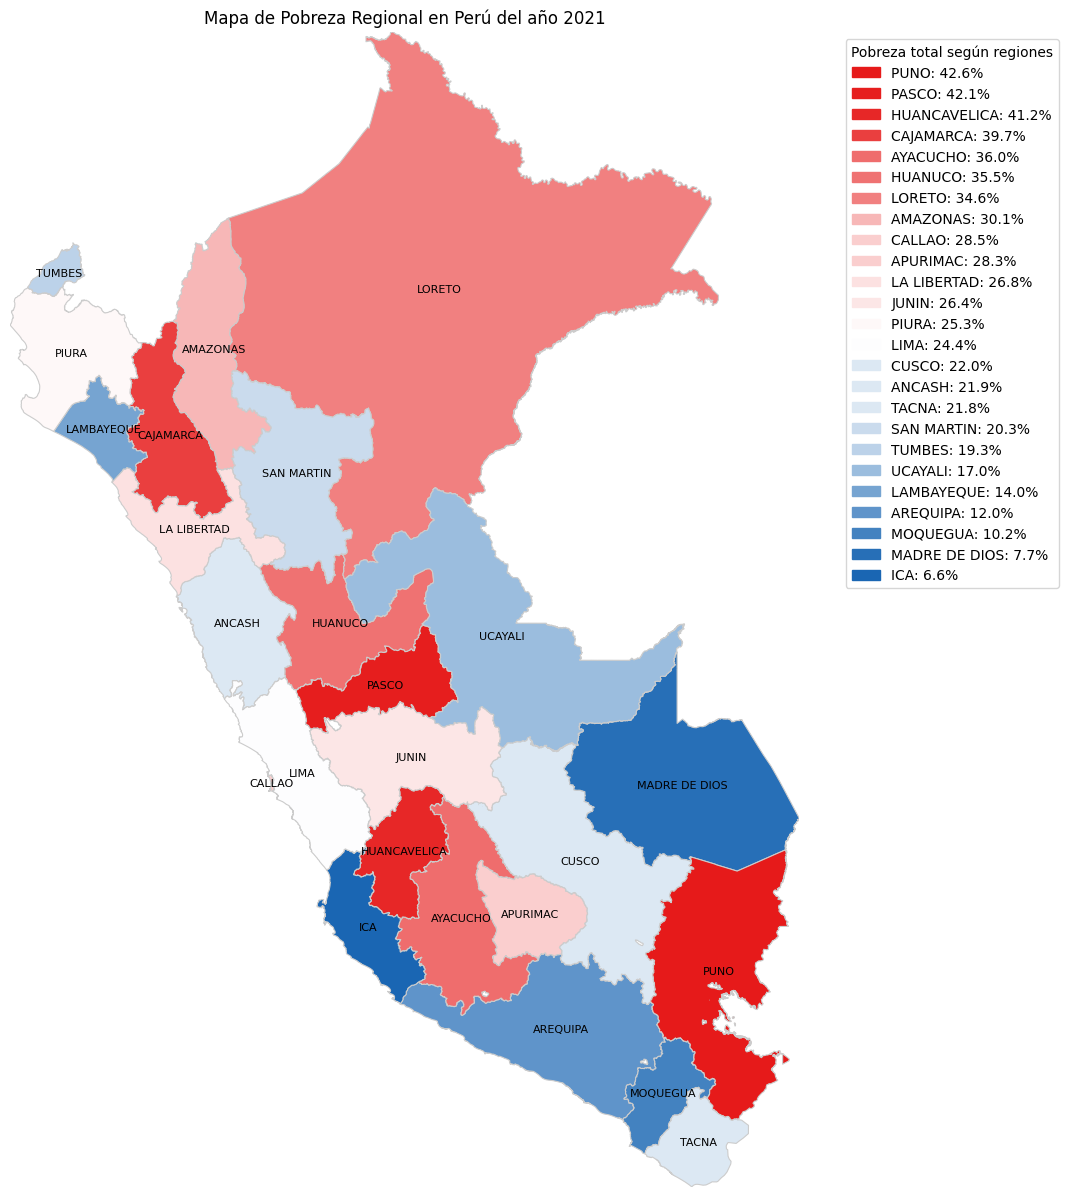

In [1]:
#Montamos google drive para la lectura de los archivos a utilizar
from google.colab import drive
drive.mount('/content/drive')


# Instalamos las librerias geopandas y matplotlib
!pip install geopandas matplotlib

# Importamos las librerias necesarias
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap



# Especifica la ruta al archivo Shapefile en Google Drive
peru_departamental = '/content/drive/MyDrive/BD_INEI/departamental/LIMITE_DEPARTAMENTAL_INEI_geogpsperu.shp'
peru_provincial = '/content/drive/MyDrive/BD_INEI/provincial/INEI_LIMITE_PROVINCIAL_196_GEOGPSPERU_JUANSUYO_931381206.shp'
peru_distrital = '/content/drive/MyDrive/BD_INEI/distrital/Distrital_INEI_2023_geogpsperu_SuyoPomalia.shp'


# Cargar el shapefile
departamental = gpd.read_file(peru_departamental)
provincial = gpd.read_file(peru_provincial)
distrital = gpd.read_file(peru_distrital)




# Cargamos el archivo csv donde se encuentra la BD.
pobreza_path_0 = '/content/drive/MyDrive/BD_INEI/OWN_BD/Peru_Pobreza_2021.csv'

datos_pobreza_1 = pd.read_csv(pobreza_path_0, encoding='ISO-8859-1')


# Campo común para unir los datos
campo_comun = 'DEPARTAMEN'

# Unimos los datos geoespaciales con los datos de pobreza
peru_pobreza_departamental = departamental.merge(datos_pobreza_1, how='left', left_on=campo_comun, right_on=campo_comun)


# Convertir la columna 'pobreza' a porcentaje
peru_pobreza_departamental['POBREZA'] = peru_pobreza_departamental['POBREZA'] * 100


# Crear una paleta de colores personalizada combinando OrRd, blanco y Blues
colors = [(0.1, 0.4, 0.7), (1, 1, 1), (0.9, 0.1, 0.1)]  # Azul claro, blanco, Rojo

cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=100)


# Creamos la figura del mapa especificando su tamaño
fig, ax = plt.subplots(1,1, figsize=(15,15))
peru_pobreza_departamental.plot(column='POBREZA', ax=ax, legend=False, cmap=cmap, linewidth=0.8, edgecolor='0.8')

# Remover el marco y las limitaciones del mapa
ax.set_axis_off()
ax.set_xlim(peru_pobreza_departamental.total_bounds[0], peru_pobreza_departamental.total_bounds[2])
ax.set_ylim(peru_pobreza_departamental.total_bounds[1], peru_pobreza_departamental.total_bounds[3])


# Ordenar los datos por porcentaje de pobreza de mayor a menor
peru_pobreza_departamental_sorted = peru_pobreza_departamental.sort_values(by='POBREZA', ascending=False)

# Crear una leyenda personalizada
norm = Normalize(vmin=peru_pobreza_departamental['POBREZA'].min(), vmax=peru_pobreza_departamental['POBREZA'].max())
sm = ScalarMappable(norm=norm, cmap=cmap)

# Crear parches para cada departamento
patches = []
for idx, row in peru_pobreza_departamental_sorted.iterrows():
    color = cmap(norm(row['POBREZA']))
    patch = mpatches.Patch(color=color, label=f"{row['DEPARTAMEN']}: {row['POBREZA']:.1f}%")
    patches.append(patch)

# Añadir la leyenda personalizada
plt.legend(handles=patches, title="Pobreza total según regiones", bbox_to_anchor=(1.05, 1), loc='upper left')


# Iterar sobre cada fila del DataFrame y agregar anotaciones en el gráfico
for idx, row in peru_pobreza_departamental.iterrows():
    # Obtener las coordenadas del centroide
    centroid_x = row['geometry'].centroid.x
    centroid_y = row['geometry'].centroid.y

    # Anotar el nombre del departamento
    plt.annotate(
        text=row['DEPARTAMEN'],
        xy=(centroid_x, centroid_y),  # Posición de la anotación
        xytext=(0, 0),  # Desplazamiento de la anotación
        textcoords="offset points",
        ha='center',  # Alineación horizontal
        va='center',  # Alineación vertical
        fontsize=8
    )

# Mostrar el mapa
plt.title('Mapa de Pobreza Regional en Perú del año 2021')
plt.savefig(f'mapa_pobreza_2021.pdf', format='pdf', bbox_inches='tight')
plt.savefig(f'mapa_pobreza_2021.svg', format='svg', bbox_inches='tight')
plt.show()